In [2]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


In [1]:
import io
import os
from imp import reload
from pathlib import Path
from pprint import pprint
from typing import Callable, List, Optional, Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as numpy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.io import read_image
from tqdm import tqdm

import tools
import wandb
from custom_datasets.single_photo_dataset import SinglePhotoDataset

repo_path = tools.wandb_login()

seed = 42

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
print(f"[INFO]: Computation device: {device}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


yoyo


wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [108]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="Naive Network",
    job_type="test",
)


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
max_error,▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,37
idx_max_error,orientation-2_std
max_error,801.15614
train_loss,6.21631
val_loss,6.21047


In [109]:
config = wandb.config
config.train_val_split = 0.7
config.seed = 42
config.batch_size = 32
config.learning_rate = 0.01
config.device = device
config.momentum = 0.9
config.architecture = "VGG"
config.input_width = 64
config.weight_decay = 0.0005
config.epochs = 100
config.frac_sample = 0.3
torch.manual_seed(config.seed)


In [110]:
topLevelFolder = repo_path / "REV1_600"
path_to_revs = topLevelFolder / "REV1_6003D_model"
path_to_fabrics = topLevelFolder / "fabrics.txt"
path_to_slices = topLevelFolder / "REV1_600Slices"


In [111]:
data_at = run.use_artifact("raw_fabrics" + ":3_images")
data_dir = data_at.download()
fabrics_df = tools.convert_table_to_dataframe(data_at.get("fabrics"))
fabrics_df = fabrics_df.sample(frac=config.frac_sample, random_state=config.seed)
single_entry_df = tools.convert_into_single_entry_df(fabrics_df)

train_df, test_df = train_test_split(
    single_entry_df,
    train_size=config.train_val_split,
    random_state=config.seed,
    shuffle=True,
)
transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config.input_width, config.input_width)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    ]
)
train_dataset = SinglePhotoDataset(train_df, normalization=True, transform=transform)
validation_dataset = SinglePhotoDataset(
    test_df, normalization=[train_dataset.max, train_dataset.min], transform=transform
)
test_df


,id,orientation-0_mean,orientation-0_std,orientation-1_mean,orientation-1_std,orientation-2_mean,orientation-2_std,orientation-3_mean,orientation-3_std,orientation-4_mean,...,aspectratio-1_mean,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photo
0,Spec-276,0.346203,0.303184,0.350613,0.009253,0.010861,-0.005511,0.321091,0.299873,0.321504,...,0.138429,0.117971,11.936543,2.626642,0.924951,0.076068,0.281719,0.128734,0.266809,REV1_600/REV1_600Slices/3pics/Spec-276_Imgs/y-...
1,Spec-495,0.135788,0.128172,0.736040,0.246269,-0.033800,-0.014523,0.140194,0.120246,0.159220,...,0.138109,0.108040,11.206256,2.109776,0.927656,0.073214,0.275600,0.117898,0.091044,REV1_600/REV1_600Slices/3pics/Spec-495_Imgs/y-...
2,Spec-259,0.340313,0.334314,0.325373,-0.002527,0.004640,-0.008812,0.312597,0.315064,0.305831,...,0.135555,0.119825,12.113477,3.167138,0.903396,0.109568,0.280899,0.126503,0.392032,REV1_600/REV1_600Slices/3pics/Spec-259_Imgs/x-...
3,Spec-220,0.344736,0.324219,0.331045,0.006693,0.013851,-0.001983,0.315346,0.308032,0.306664,...,0.136831,0.113031,12.282974,2.863388,0.920155,0.089973,0.278408,0.121238,0.264827,REV1_600/REV1_600Slices/3pics/Spec-220_Imgs/x-...
4,Spec-93,0.313709,0.329182,0.357109,-0.022117,-0.012678,0.003006,0.308046,0.310686,0.319504,...,0.138794,0.097598,8.894725,2.314832,0.874835,0.054807,0.207878,0.082039,0.102170,REV1_600/REV1_600Slices/3pics/Spec-93_Imgs/x-y...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,Spec-424,0.029653,0.029694,0.940652,-0.003912,0.002092,0.001535,0.079944,0.073707,0.119358,...,0.136690,0.116803,11.169196,2.484957,0.924744,0.083752,0.278640,0.126545,0.318482,REV1_600/REV1_600Slices/3pics/Spec-424_Imgs/x-...
482,Spec-555,0.476792,0.469737,0.053472,-0.002521,0.006296,0.010684,0.346576,0.345233,0.108593,...,0.138394,0.121030,11.366687,2.661477,0.911728,0.101624,0.281073,0.129846,0.337174,REV1_600/REV1_600Slices/3pics/Spec-555_Imgs/x-...
483,Spec-232,0.338178,0.332867,0.328955,-0.023052,0.012305,-0.009179,0.309102,0.312037,0.306917,...,0.143984,0.118344,11.856317,2.555054,0.920047,0.081056,0.283813,0.126899,0.151886,REV1_600/REV1_600Slices/3pics/Spec-232_Imgs/x-...
484,Spec-156,0.343691,0.325548,0.330761,-0.009509,0.001009,0.003796,0.317661,0.310226,0.310788,...,0.136542,0.103896,11.705801,3.268533,0.874502,0.055716,0.217263,0.088377,0.339927,REV1_600/REV1_600Slices/3pics/Spec-156_Imgs/x-...


In [112]:
class VGG11(nn.Module):
    def __init__(self, input_channel, input_width, output_size):
        super(VGG11, self).__init__()
        self.in_channels = input_channel
        self.output_size = output_size
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )

        input_fc = int((input_width / (2 ** 4)) ** 2 * 512)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_fc, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.output_size),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = VGG11(input_channel=1, input_width=config.input_width, output_size=23).to(
    device
)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")


[INFO]: 54,361,879 trainable parameters.


In [113]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, **kwargs
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=config.batch_size,
    shuffle=False,
)
loss = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

config.model_type = type(model)
config.loss_type = type(loss)
config.optimizer_type = type(optimizer)


torch.Size([23])


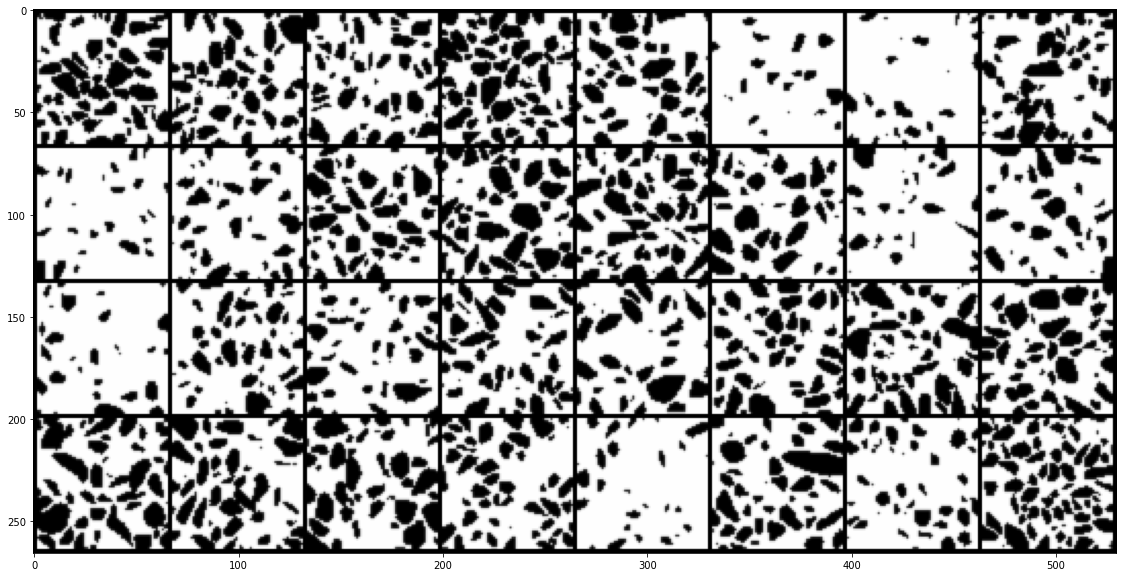

In [52]:
first_batch = next(train_dataloader._get_iterator())
images = first_batch[0]
labels = first_batch[1]
print(labels[0].shape)

labels = first_batch[1]
grid = utils.make_grid(images)

fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


In [114]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader, total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss


def validate(model, device, val_loader, criterion, min, max):
    model.eval()
    val_loss = 0
    example_images = []
    with torch.no_grad():
        for idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            example_images.append(wandb.Image(data[0]))
            error = (output - target) / (target + (min / (max - min)))
            if idx == 0:
                errors = error
            else:
                errors = torch.cat((errors, error), dim=0)
    return val_loss, example_images, error.max()


In [115]:
train_loss, val_loss, max_error = [], [], []

for epoch in range(1, config.epochs + 1):
    current_train_loss = train(model, device, train_dataloader, optimizer, loss)
    current_val_loss, _, current_max_error = validate(
        model,
        device,
        validation_dataloader,
        loss,
        validation_dataset.min,
        validation_dataset.max,
    )

    train_loss.append(current_train_loss)
    val_loss.append(current_val_loss)
    max_error.append(current_max_error)
    print(
        "{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}".format(
            "train loss",
            current_train_loss,
            "val loss",
            current_val_loss,
            "max error",
            current_max_error,
        )
    )

    wandb.log(
        {
            "train_loss": current_train_loss,
            "val_loss": current_val_loss,
            "max_error": current_max_error,
            "epoch": epoch,
        }
    )


100%|██████████| 36/36 [00:35<00:00,  1.02it/s]


train loss   804518.5195220858             
val loss     3.472454532980919             
max error    8.646303529787692             


100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


train loss   7.769519478082657             
val loss     2.9831268936395645            
max error    10.052634543683128            


100%|██████████| 36/36 [00:36<00:00,  1.00s/it]


train loss   7.272268980741501             
val loss     2.853564664721489             
max error    10.568515695985917            


 67%|██████▋   | 24/36 [00:26<00:13,  1.09s/it]


KeyboardInterrupt: 